Домашнее задание

- Обучите CNN (самописная) на CIFAR-100.
- Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
# функция для обучения и валидации модели

def train_val_model(net, num_epochs, train_loader, valid_loader):
    for epoch in range(num_epochs):  
        net.train()
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обучение
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if i % 300 == 0:    # печатаем каждые 300 mini-batches
                net.eval()

                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}. ' \
                      f'Acc: {running_right / running_items:.3f}', end='. ')
                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(valid_loader):

                    test_outputs = net(data[0].to(device))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

                print(f'Test acc: {test_running_right / test_running_total:.3f}')

    print('Training is finished!')

In [4]:
# загружаем датасет
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

dataset = datasets.CIFAR100(root='data/',
                            train=True, 
                            download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [5]:
classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm')

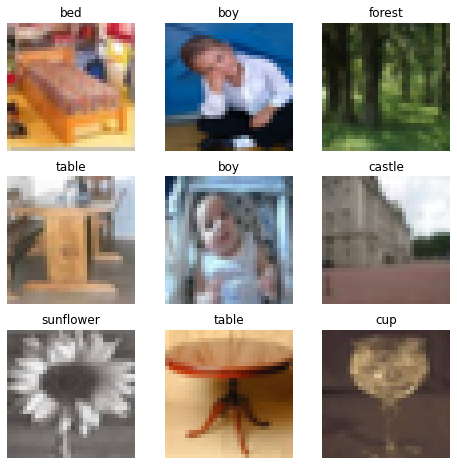

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [7]:

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test


class MyOwnCifar100(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]  
        if self.transform is not None:
            img = self.transform(img)
        label = self._base_dataset[idx][1] 
        return img, label


trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])



In [8]:

train_dataset, valid_dataset = train_valid_split(dataset)

#формируем экземпляры классов (тензор, класс)
train_dataset = MyOwnCifar100(train_dataset, trans_actions)
valid_dataset = MyOwnCifar100(valid_dataset, transforms.ToTensor())
print('Количество экземплятор в тренировочном датасете: ', len(train_dataset))
print('Количество экземплятор в валидационном датасете: ', len(valid_dataset))


train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

Количество экземплятор в тренировочном датасете:  47500
Количество экземплятор в валидационном датасете:  2500


In [9]:

#батч 128 из тензора размера (3,32,32), 128 меток классов
train_features, train_labels = next(iter(train_loader))
print(train_features.shape, train_labels.shape)
train_features, train_labels

torch.Size([128, 3, 32, 32]) torch.Size([128])


(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.4706, 0.4706, 0.4706,  ..., 0.5333, 0.4784, 0.4353],
           [0.5412, 0.5529, 0.5765,  ..., 0.4941, 0.4275, 0.3804],
           [0.6118, 0.6314, 0.6824,  ..., 0.4431, 0.3804, 0.3373]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.3373, 0.3333, 0.3294,  ..., 0.5098, 0.4549, 0.4157],
           [0.4078, 0.4275, 0.4627,  ..., 0.4706, 0.4078, 0.3608],
           [0.4667, 0.5059, 0.5804,  ..., 0.4275, 0.3647, 0.3255]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

In [10]:
torch.manual_seed(10)

In [11]:
# CNN

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60) 
        self.conv_two = torch.nn.Conv2d(60, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 240, 3)
        self.bn_four = torch.nn.BatchNorm2d(240)
        self.fc1 = torch.nn.Linear(960, 400)
        self.out = torch.nn.Linear(400, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        return self.out(x)

In [12]:
net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
num_epochs = 10
train_val_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/10]. Step [1/372]. Loss: 0.036. Acc: 0.016. Test acc: 0.007
Epoch [1/10]. Step [301/372]. Loss: 0.032. Acc: 0.068. Test acc: 0.112
Epoch [2/10]. Step [1/372]. Loss: 0.075. Acc: 0.070. Test acc: 0.082
Epoch [2/10]. Step [301/372]. Loss: 0.028. Acc: 0.149. Test acc: 0.175
Epoch [3/10]. Step [1/372]. Loss: 0.046. Acc: 0.180. Test acc: 0.081
Epoch [3/10]. Step [301/372]. Loss: 0.026. Acc: 0.194. Test acc: 0.193
Epoch [4/10]. Step [1/372]. Loss: 0.043. Acc: 0.188. Test acc: 0.198
Epoch [4/10]. Step [301/372]. Loss: 0.025. Acc: 0.228. Test acc: 0.217
Epoch [5/10]. Step [1/372]. Loss: 0.040. Acc: 0.203. Test acc: 0.229
Epoch [5/10]. Step [301/372]. Loss: 0.024. Acc: 0.256. Test acc: 0.209
Epoch [6/10]. Step [1/372]. Loss: 0.044. Acc: 0.156. Test acc: 0.265
Epoch [6/10]. Step [301/372]. Loss: 0.023. Acc: 0.279. Test acc: 0.231
Epoch [7/10]. Step [1/372]. Loss: 0.041. Acc: 0.109. Test acc: 0.243
Epoch [7/10]. Step [301/372]. Loss: 0.022. Acc: 0.297. Test acc: 0.269
Epoch [8/10]. Step [

По результатам заметно, что модель подвержена переобучению.

дообучение ImageNet Resnet-50

In [15]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [19]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [20]:
resnet50 = resnet50.to(device)

In [21]:
trans_actions = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                                    ])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar100(train_dataset, trans_actions)
valid_dataset = MyOwnCifar100(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [22]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
num_epochs = 5
net = resnet50
train_val_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/5]. Step [1/372]. Loss: 0.037. Acc: 0.016. Test acc: 0.010
Epoch [1/5]. Step [301/372]. Loss: 0.017. Acc: 0.468. Test acc: 0.211
Epoch [2/5]. Step [1/372]. Loss: 0.023. Acc: 0.336. Test acc: 0.217
Epoch [2/5]. Step [301/372]. Loss: 0.011. Acc: 0.624. Test acc: 0.215
Epoch [3/5]. Step [1/372]. Loss: 0.019. Acc: 0.375. Test acc: 0.217
Epoch [3/5]. Step [301/372]. Loss: 0.009. Acc: 0.666. Test acc: 0.199
Epoch [4/5]. Step [1/372]. Loss: 0.020. Acc: 0.359. Test acc: 0.210
Epoch [4/5]. Step [301/372]. Loss: 0.008. Acc: 0.692. Test acc: 0.208
Epoch [5/5]. Step [1/372]. Loss: 0.020. Acc: 0.352. Test acc: 0.199
Epoch [5/5]. Step [301/372]. Loss: 0.008. Acc: 0.713. Test acc: 0.200
Training is finished!


Модель так же неэффективна и переобучена